# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. I will be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')
random = 42
tqdm.pandas()

## Load Data

In [3]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [4]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

## EDA

Let's check the negative and positive reviews ratio.

In [5]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

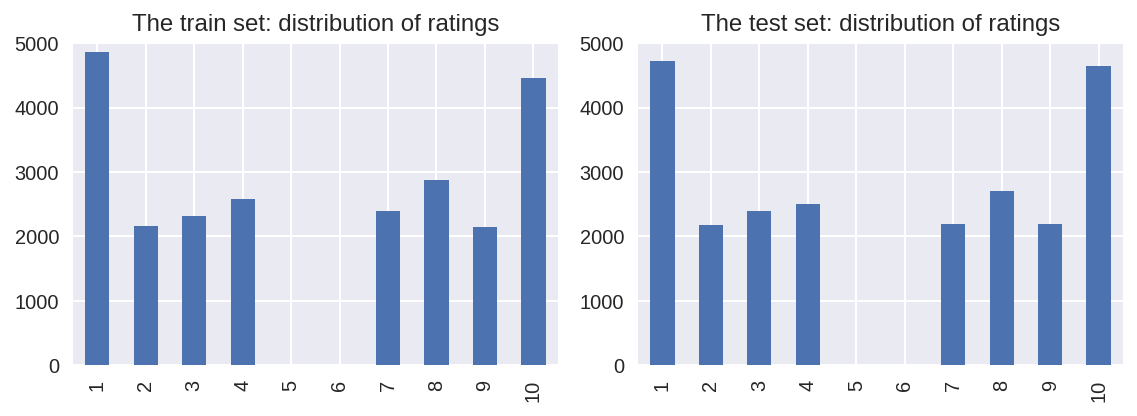

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

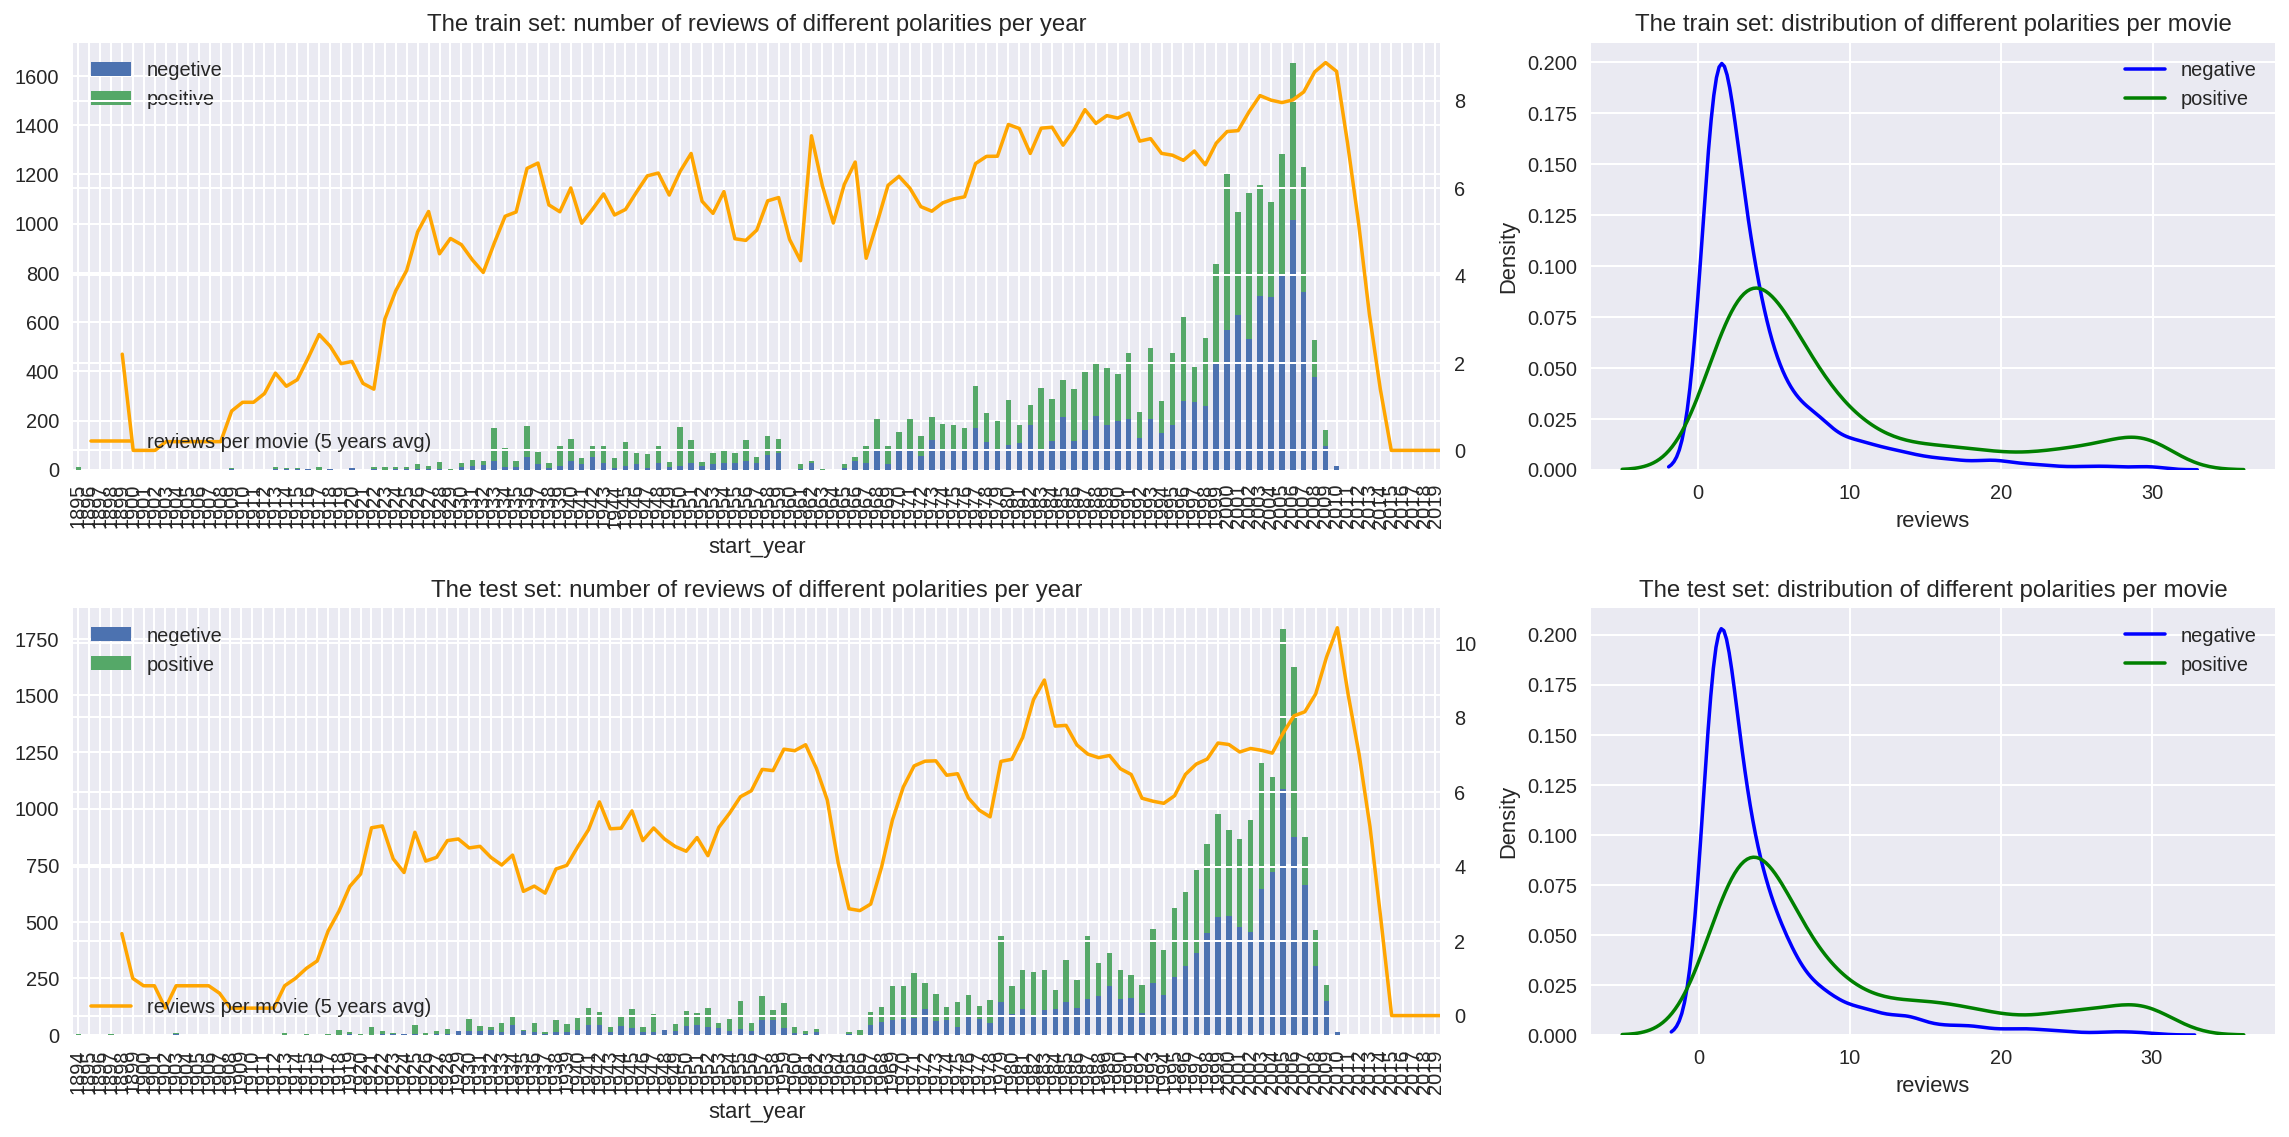

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]
dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax,)
ax.set_title('The train set: number of reviews of different polarities per year')
ax.legend(['negetive','positive'],loc=2)

dft1 = df_reviews.query('ds_part == "train"')[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft2 = df_reviews.query('ds_part == "train"')['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (5 years avg)', ax=axt)
axt.legend(loc=3)

ax = axs[0][1]
dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.set_title('The train set: distribution of different polarities per movie')
ax.set_xlabel('reviews')
ax.legend()

ax = axs[1][0]
dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')
ax.legend(['negetive','positive'],loc=2)

dft1 = df_reviews.query('ds_part == "test"')[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft2 = df_reviews.query('ds_part == "test"')['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (5 years avg)', ax=axt)
axt.legend(loc=3)

ax = axs[1][1]
dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.set_title('The test set: distribution of different polarities per movie')
ax.set_xlabel('reviews')
ax.legend()

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [8]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [9]:
import re

def review_norm_f(row):
    pattern = r"[^a-zA-Z']"
    text = row['review']
    text = re.sub(pattern, " ", text)
    text = text.lower().split()
    text = " ".join(text)
    return text

df_reviews['review_norm'] = df_reviews.apply(review_norm_f, axis=1) 

In [10]:
df_reviews[['review','review_norm']].head(5)

,review,review_norm
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...
1,How the hell did they get this made?! Presenti...,how the hell did they get this made presenting...
2,There is no real story the film seems more lik...,there is no real story the film seems more lik...
3,Um .... a serious film about troubled teens in...,um a serious film about troubled teens in sing...
4,I'm totally agree with GarryJohal from Singapo...,i'm totally agree with garryjohal from singapo...


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [11]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


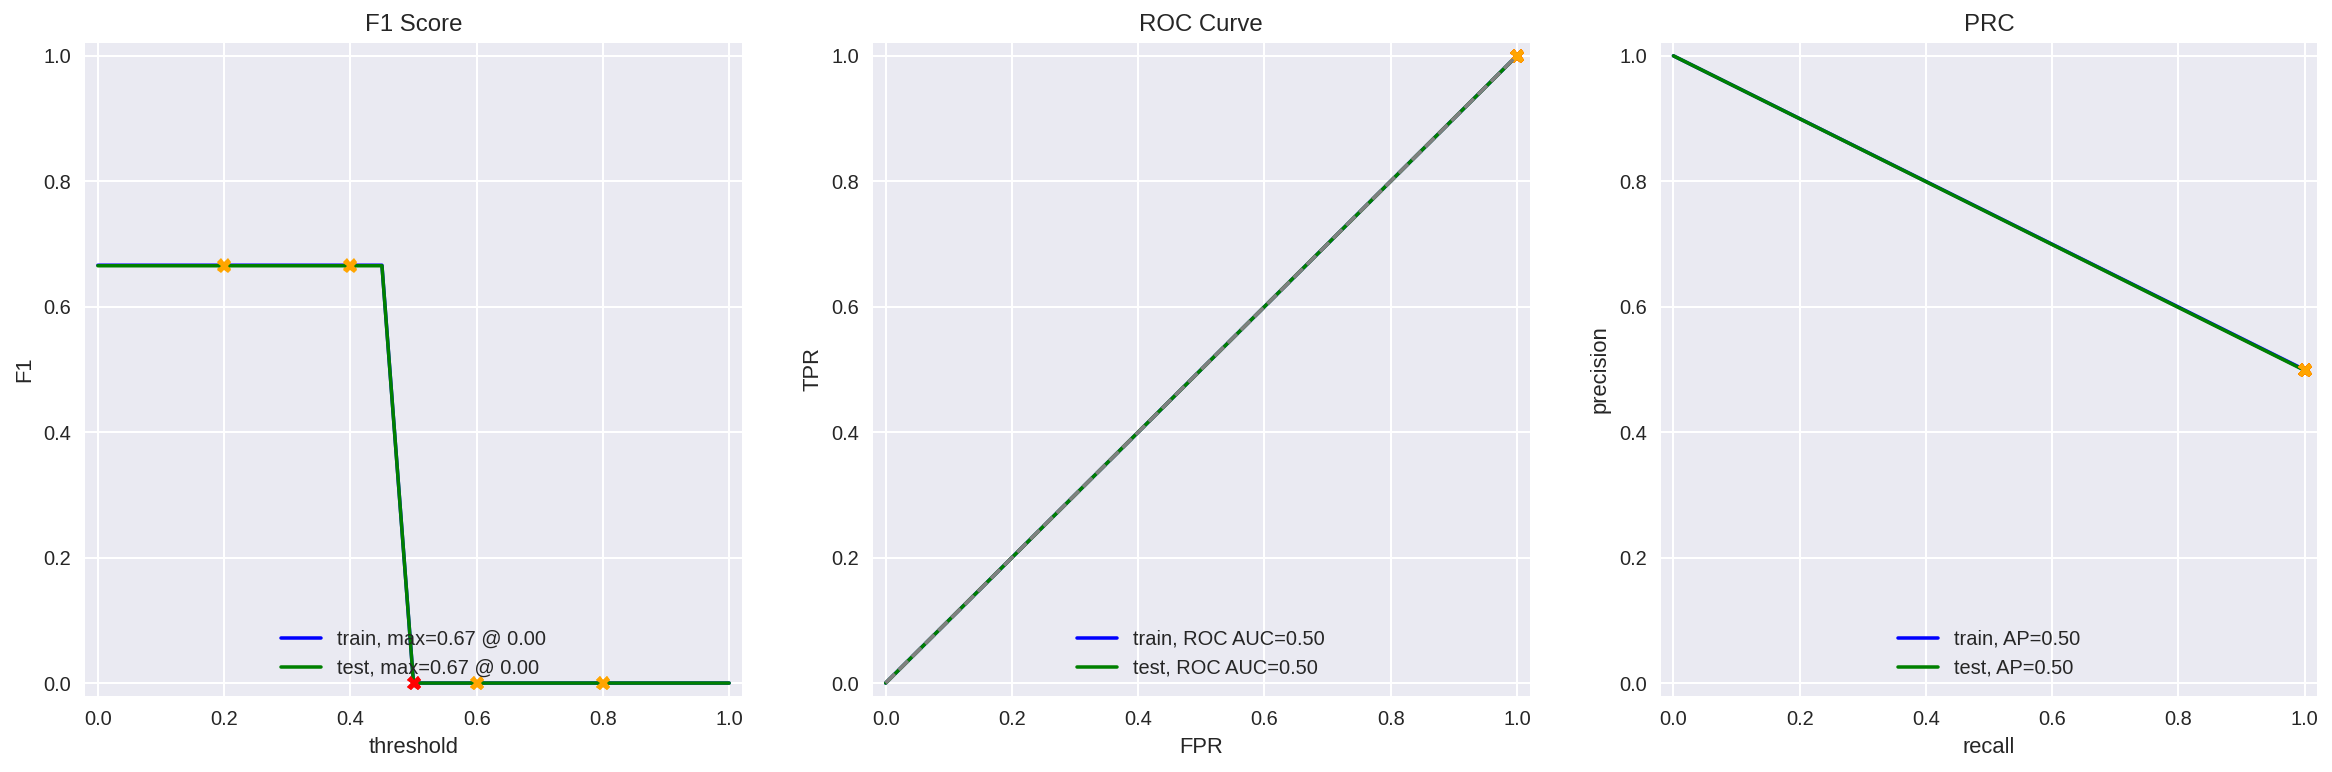

In [12]:
from sklearn.dummy import DummyClassifier
model_0 = DummyClassifier(constant=1).fit(df_reviews_train.review_norm, train_target)
evaluate_model(model_0, df_reviews_train.review_norm, train_target, df_reviews_test.review_norm, test_target)

### Model 1 - NLTK, TF-IDF and LR

In [13]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords as nltk_stopwords

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


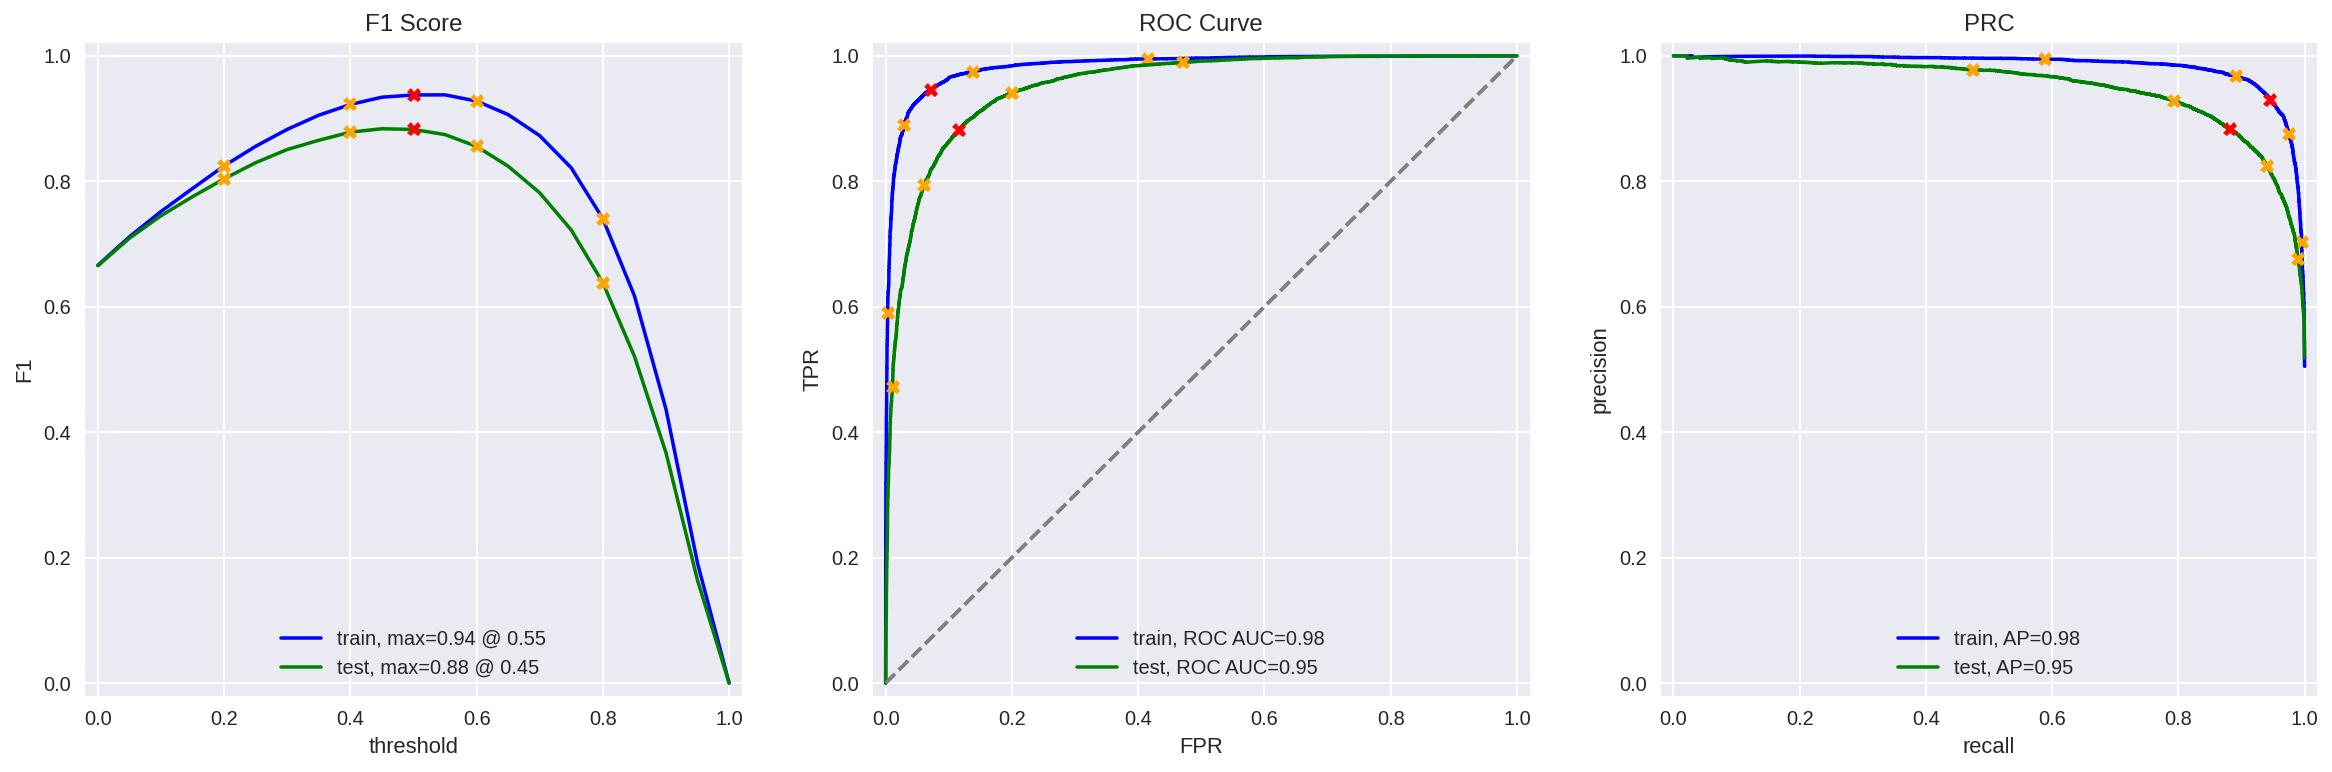

In [37]:
stop_words = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

tf_idf_train = count_tf_idf.fit_transform( df_reviews_train.review_norm ) 
tf_idf_test = count_tf_idf.transform( df_reviews_test.review_norm ) 

model_1 = LogisticRegression().fit(tf_idf_train, train_target)
evaluate_model(model_1, tf_idf_train, train_target, tf_idf_test, test_target)

### Model 2 - spaCy, TF-IDF and LR

In [15]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def text_preprocessing_nlp(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

In [16]:
%%time
df_reviews['review_nlp'] = df_reviews.review.apply(lambda x: text_preprocessing_nlp(x)) 

CPU times: user 13min 15s, sys: 1.54 s, total: 13min 17s
Wall time: 13min 18s


          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


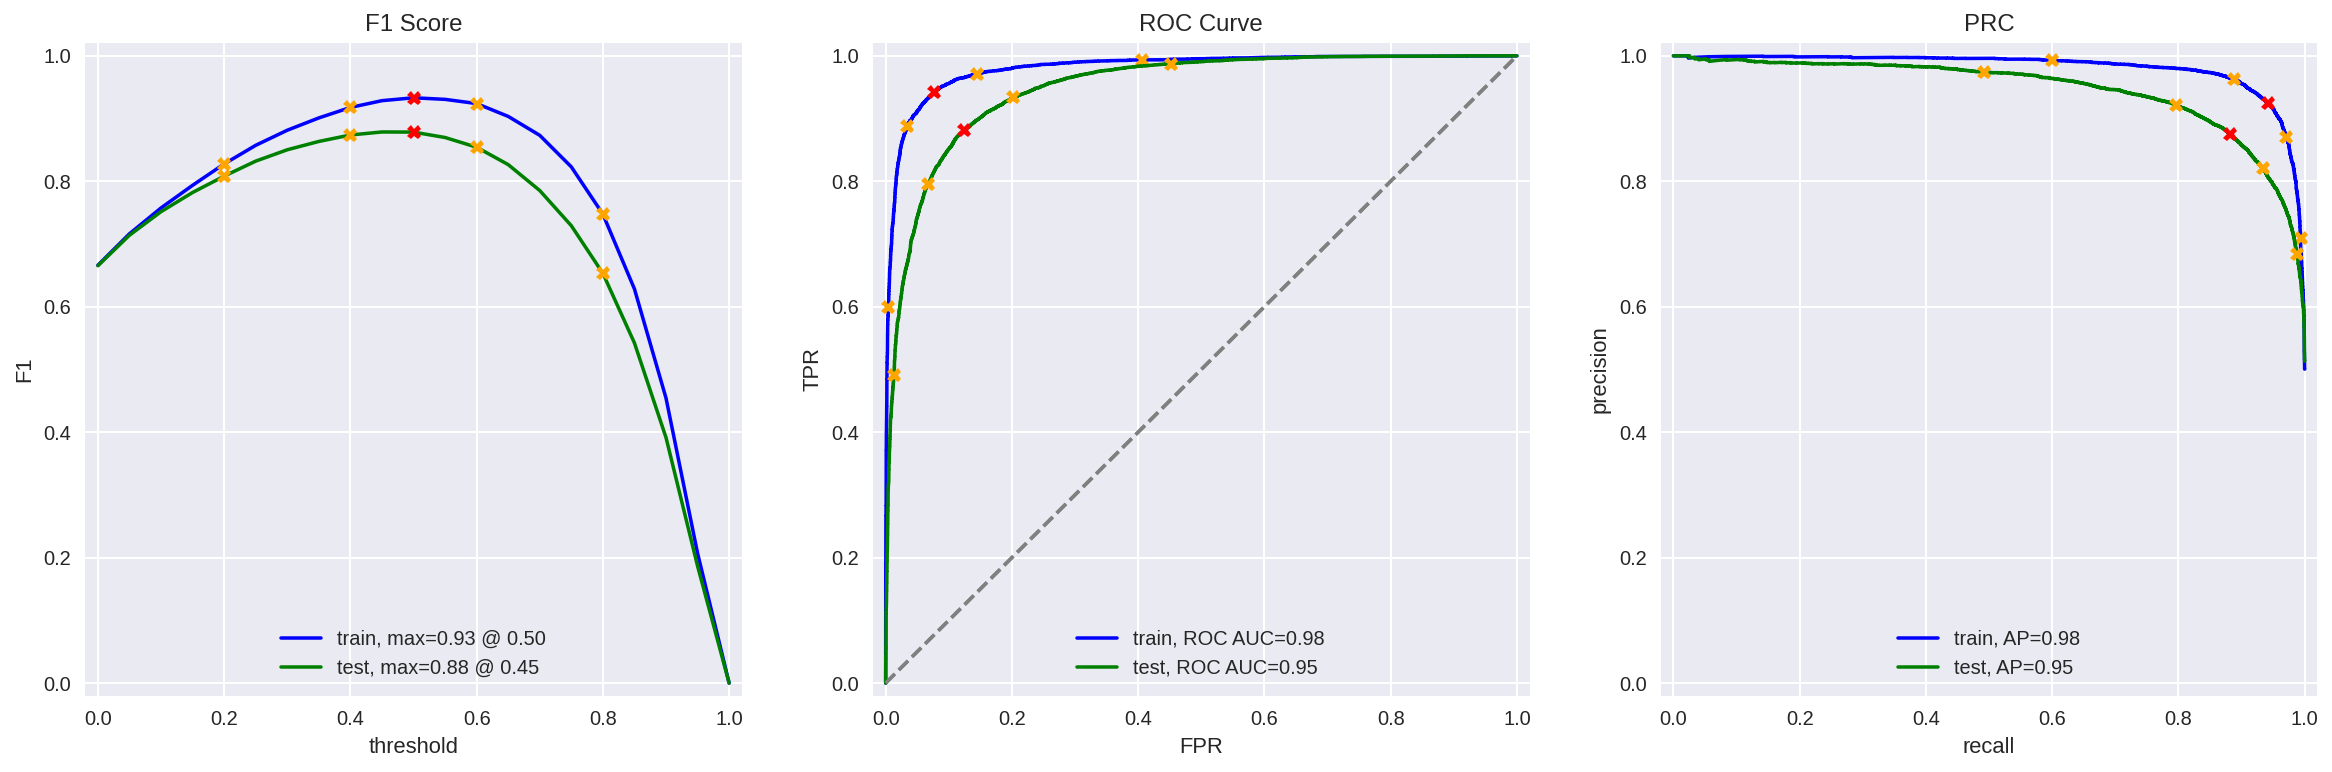

In [36]:
count_tf_idf2 = TfidfVectorizer(stop_words=stop_words)

train_f2 = count_tf_idf2.fit_transform(df_reviews.query('ds_part == "train"').review_nlp) 
test_f2 = count_tf_idf2.transform(df_reviews.query('ds_part == "test"').review_nlp)

model_2 = LogisticRegression().fit(train_f2, train_target)
evaluate_model(model_2, train_f2, train_target, test_f2, test_target)

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [ ]:
%%time
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_test ={'num_leaves': sp_randint(6, 40), 
             'min_child_samples': sp_randint(10, 100), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1],
             'reg_lambda': [0, 1e-1]}


clf = LGBMClassifier(max_depth = -1, 
                     random_state = random, 
                     silent=True, 
                     metric='None', 
                     n_jobs=-1,
                     n_estimators=100)

rf_random = RandomizedSearchCV(estimator=clf, 
                               param_distributions = param_test, 
                               n_iter= 20,
                               scoring='f1',
                               cv=10,
                               refit=True,
                               random_state=random,
                               verbose=2,
                               n_jobs = -1)

model_3 = rf_random.fit(train_f2, train_target)

          train  test
Accuracy   0.91  0.86
F1         0.92  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94
CPU times: user 1min 10s, sys: 403 ms, total: 1min 10s
Wall time: 1min 11s


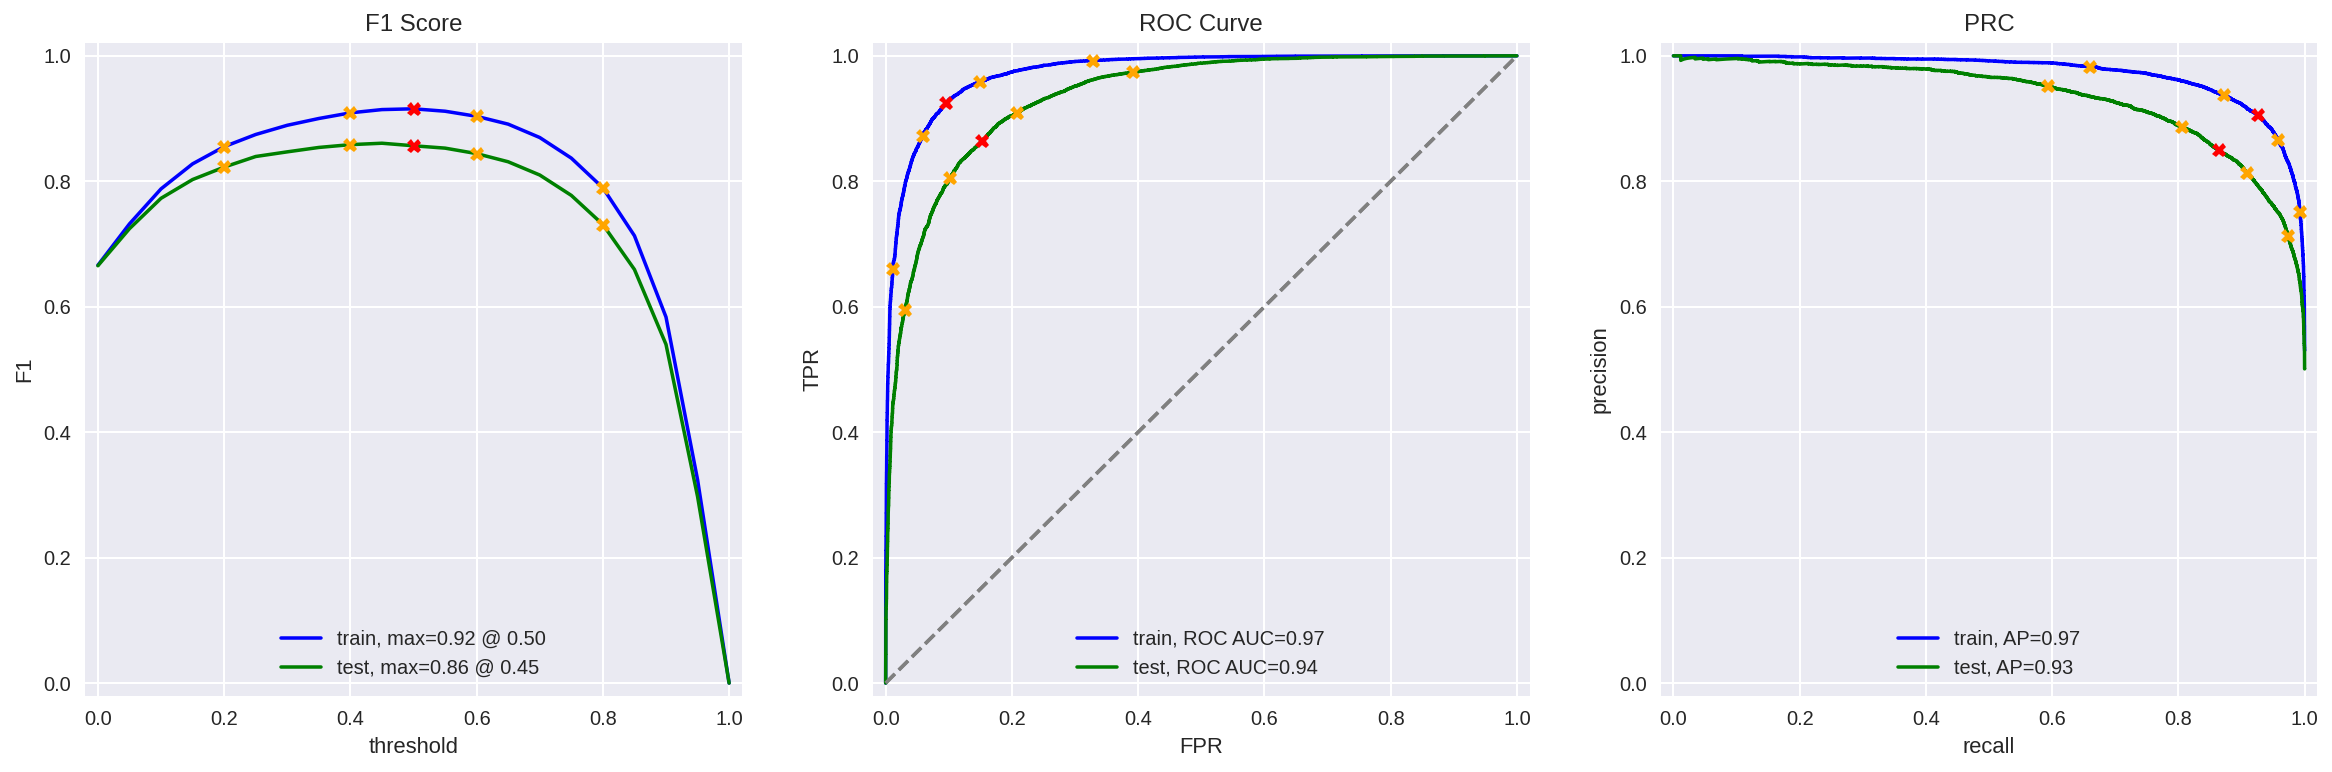

In [19]:
%%time
from lightgbm import LGBMClassifier
model_3 = LGBMClassifier().fit(train_f2, train_target)
evaluate_model(model_3, train_f2, train_target, test_f2, test_target)

          train  test
Accuracy   0.92  0.86
F1         0.92  0.86
APS        0.97  0.94
ROC AUC    0.97  0.94
CPU times: user 1.39 s, sys: 11.5 ms, total: 1.4 s
Wall time: 1.4 s


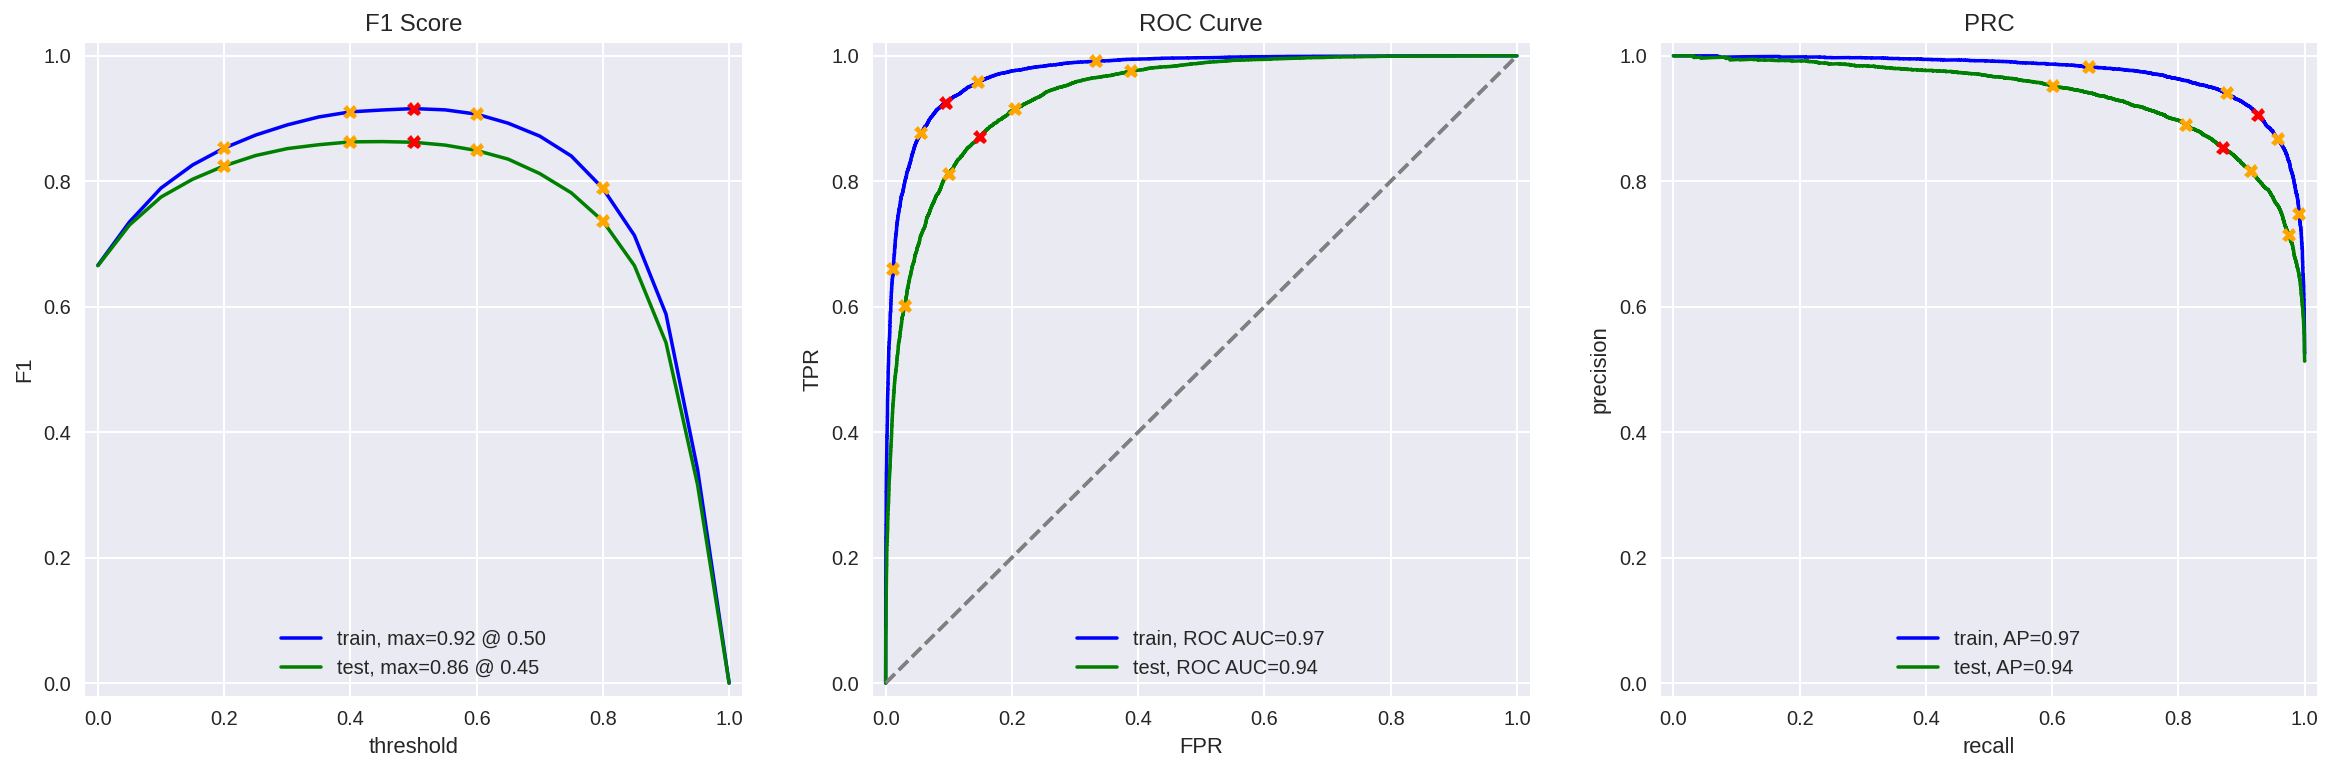

In [88]:
%%time
evaluate_model(model_3, train_f2, train_target, test_f2, test_target)

## My Reviews

In [49]:
my_reviews = pd.DataFrame([
    'Very good movie',
    'highly recomanded',
    'masterpiece!',
    'fun extravaganza',
    'I have mixed feelings about this one',
    'It is quite interesting, not every day you watch movie as exciting as drying paint',
    'Will not recommend to my friends',
    'a good use for 120 min',
    'didn\'t understand the movie'
], columns=['review'])

my_reviews['review_norm'] = my_reviews.apply(review_norm_f, axis=1) 
my_reviews['review_nlp'] = my_reviews.review.apply(lambda x: text_preprocessing_nlp(x)) 
my_reviews

,review,review_norm,review_nlp
0,Very good movie,very good movie,very good movie
1,highly recomanded,highly recomanded,highly recomande
2,masterpiece!,masterpiece,masterpiece !
3,fun extravaganza,fun extravaganza,fun extravaganza
4,I have mixed feelings about this one,i have mixed feelings about this one,I have mixed feeling about this one
5,"It is quite interesting, not every day you wat...",it is quite interesting not every day you watc...,"it be quite interesting , not every day you wa..."
6,Will not recommend to my friends,will not recommend to my friends,will not recommend to my friend
7,a good use for 120 min,a good use for min,a good use for 120 min
8,didn't understand the movie,didn't understand the movie,do not understand the movie


### Model 1

In [54]:
my_reviews_pred_prob = model_1.predict_proba(count_tf_idf.transform(my_reviews.review_norm))[:, 1]

for i, review in enumerate(my_reviews.review_norm.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.82:  very good movie
0.97:  highly recomanded
0.89:  masterpiece
0.82:  fun extravaganza
0.77:  i have mixed feelings about this one
0.56:  it is quite interesting not every day you watch movie as exciting as drying paint
0.87:  will not recommend to my friends
0.47:  a good use for min
0.57:  didn't understand the movie


### Model 2

In [55]:
my_reviews_pred_prob = model_2.predict_proba(count_tf_idf2.transform(my_reviews.review_nlp))[:, 1]

for i, review in enumerate(my_reviews.review_nlp.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.95:  very good movie
0.97:  highly recomande
0.89:  masterpiece !
0.83:  fun extravaganza
0.70:  I have mixed feeling about this one
0.40:  it be quite interesting , not every day you watch movie as exciting as dry paint
0.93:  will not recommend to my friend
0.53:  a good use for 120 min
0.65:  do not understand the movie


### Model 4

In [56]:
my_reviews_pred_prob = model_3.predict_proba(count_tf_idf2.transform(my_reviews.review_norm))[:, 1]

for i, review in enumerate(my_reviews.review_norm.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.81:  very good movie
0.81:  highly recomanded
0.73:  masterpiece
0.71:  fun extravaganza
0.61:  i have mixed feelings about this one
0.70:  it is quite interesting not every day you watch movie as exciting as drying paint
0.71:  will not recommend to my friends
0.82:  a good use for min
0.61:  didn't understand the movie


## Conclusions

1. Best model: Model 1 - NLTK, TF-IDF and LR.
2. Small difference between NLTK or spaCy model preformence.
3. Logistic regretion is preforming better than LGBMClassifier.
4. All models failed to classify this negetive statment: 'Will not recommend to my friends'.